In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [92]:
from fastai.vision.all import *
import numpy as np
import pandas as pd

In [93]:
train_df = pd.read_csv("../input/identify-snake-breed-hackerearth/dataset/train.csv")
test_df = pd.read_csv("../input/identify-snake-breed-hackerearth/dataset/test.csv")

In [94]:
train_df.head()

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix


In [95]:
train_df.breed.value_counts()

thamnophis-sirtalis            509
storeria-dekayi                412
pantherophis-obsoletus         366
crotalus-atrox                 354
pituophis-catenifer            298
nerodia-sipedon                259
agkistrodon-contortrix         206
lampropeltis-triangulum        197
diadophis-punctatus            184
pantherophis-alleghaniensis    172
nerodia-erythrogaster          171
lampropeltis-californiae       166
opheodrys-aestivus             152
agkistrodon-piscivorus         147
crotalus-horridus              142
coluber-constrictor            129
heterodon-platirhinos          118
thamnophis-proximus            112
nerodia-rhombifer              104
pantherophis-guttatus          100
thamnophis-radix               100
haldea-striatula                98
pantherophis-spiloides          92
rhinocheilus-lecontei           91
storeria-occipitomaculata       87
crotalus-viridis                83
masticophis-flagellum           83
thamnophis-marcianus            82
crotalus-ruber      

In [96]:
train_df["breed"].unique()

array(['nerodia-erythrogaster', 'pantherophis-vulpinus',
       'thamnophis-sirtalis', 'pantherophis-obsoletus',
       'agkistrodon-contortrix', 'crotalus-atrox',
       'lampropeltis-triangulum', 'crotalus-horridus', 'crotalus-ruber',
       'heterodon-platirhinos', 'nerodia-sipedon', 'thamnophis-elegans',
       'thamnophis-marcianus', 'crotalus-viridis', 'nerodia-fasciata',
       'haldea-striatula', 'storeria-dekayi', 'agkistrodon-piscivorus',
       'nerodia-rhombifer', 'storeria-occipitomaculata',
       'thamnophis-radix', 'coluber-constrictor', 'natrix-natrix',
       'diadophis-punctatus', 'masticophis-flagellum',
       'pantherophis-spiloides', 'rhinocheilus-lecontei',
       'lampropeltis-californiae', 'pituophis-catenifer',
       'opheodrys-aestivus', 'pantherophis-guttatus',
       'pantherophis-alleghaniensis', 'thamnophis-proximus',
       'pantherophis-emoryi', 'crotalus-scutulatus'], dtype=object)

In [132]:
dls = ImageDataLoaders.from_df(train_df,path="../input/identify-snake-breed-hackerearth/dataset",
                               folder="train",
                               suff=".jpg",
                               label_col="breed",valid_pct=0.2,
                               item_tfms= Resize(224),
                               batch_tfms=aug_transforms(),
                              bs=16)

In [133]:
dls.vocab

['agkistrodon-contortrix', 'agkistrodon-piscivorus', 'coluber-constrictor', 'crotalus-atrox', 'crotalus-horridus', 'crotalus-ruber', 'crotalus-scutulatus', 'crotalus-viridis', 'diadophis-punctatus', 'haldea-striatula', 'heterodon-platirhinos', 'lampropeltis-californiae', 'lampropeltis-triangulum', 'masticophis-flagellum', 'natrix-natrix', 'nerodia-erythrogaster', 'nerodia-fasciata', 'nerodia-rhombifer', 'nerodia-sipedon', 'opheodrys-aestivus', 'pantherophis-alleghaniensis', 'pantherophis-emoryi', 'pantherophis-guttatus', 'pantherophis-obsoletus', 'pantherophis-spiloides', 'pantherophis-vulpinus', 'pituophis-catenifer', 'rhinocheilus-lecontei', 'storeria-dekayi', 'storeria-occipitomaculata', 'thamnophis-elegans', 'thamnophis-marcianus', 'thamnophis-proximus', 'thamnophis-radix', 'thamnophis-sirtalis']

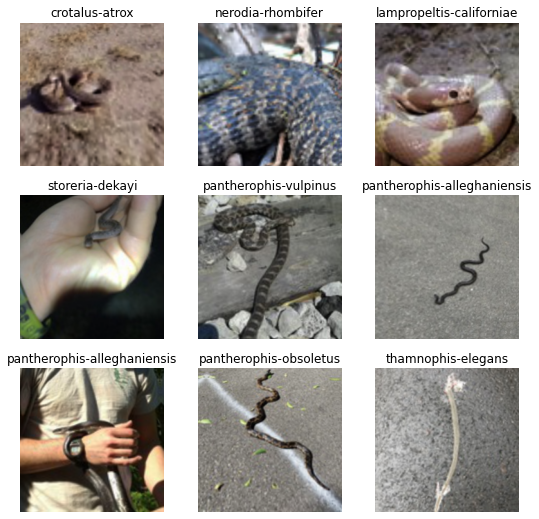

In [135]:
dls.show_batch()

In [137]:
learn = cnn_learner(dls,resnet50,metrics=accuracy)
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,3.739923,2.985212,0.274296,00:31


epoch,train_loss,valid_loss,accuracy,time
0,2.925128,2.434974,0.346049,00:41
1,2.783334,2.505728,0.331517,00:40
2,2.427388,2.213347,0.374205,00:39
3,1.966445,2.021148,0.412352,00:40
4,1.425352,2.002973,0.447775,00:39
5,1.217234,1.997996,0.451408,00:38


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

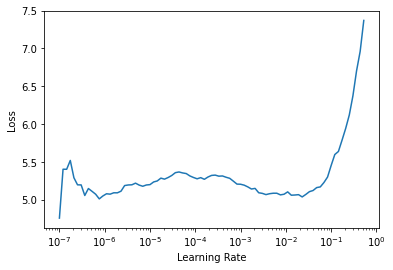

In [142]:
learn = cnn_learner(dls,resnet50,metrics=accuracy,model_dir="/kaggle/working")
learn.lr_find()

In [143]:
learn = cnn_learner(dls, resnet50, metrics=accuracy,model_dir="/kaggle/working")
learn.fit_one_cycle(10, base_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.173784,3.055860,0.266122,00:31
1,3.447791,2.582772,0.325159,00:31
2,2.940602,2.403690,0.346049,00:30
3,2.570049,2.300544,0.351499,00:31
4,2.312554,2.189784,0.384196,00:29
5,2.124218,2.079877,0.419619,00:31
6,1.868640,2.062052,0.420527,00:30
7,1.750773,2.062382,0.426885,00:31
8,1.544838,2.025533,0.427793,00:30
9,1.641488,2.034647,0.428701,00:30


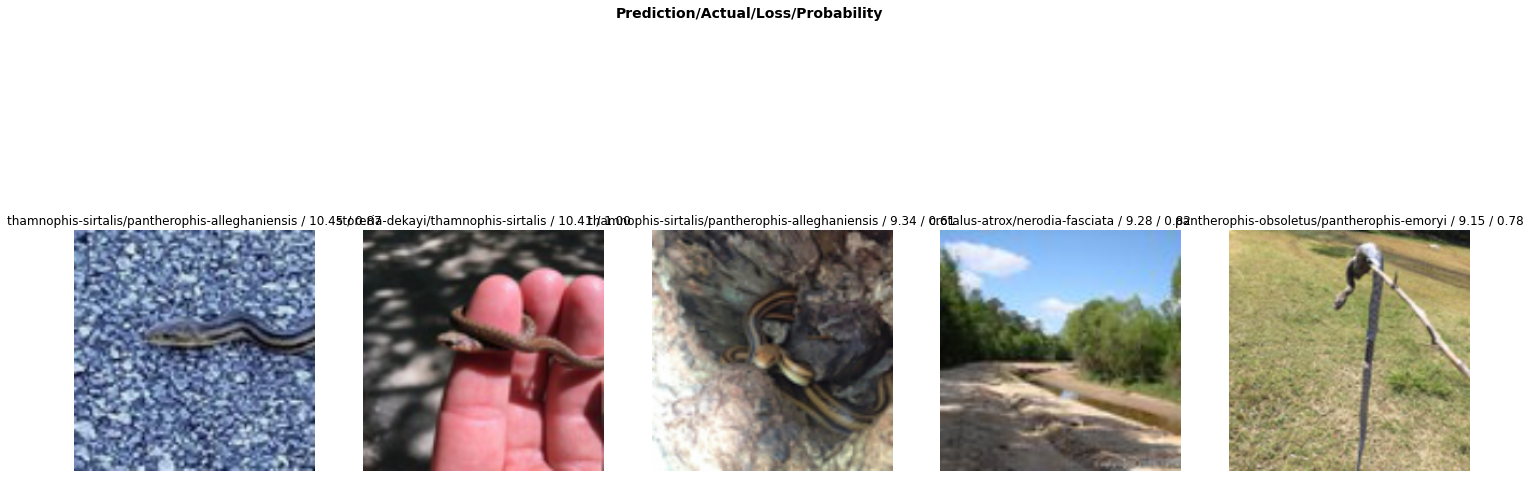

In [123]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5, nrows=1, figsize = (25,10))

In [138]:
test_path = "../input/identify-snake-breed-hackerearth/dataset/test/"
test_image_ids = [i for i in test_df.image_id]
test_images = [test_path+f"{img}.jpg" for img in test_image_ids]
preds = learn.get_preds(dl=dls.test_dl(test_images, shuffle=False, drop_last=False))

In [139]:
preds = preds[0].cpu().numpy()
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_df["breed_label"] = lb.fit_transform(train_df.breed)
pred = lb.inverse_transform((np.argmax(preds,axis=1)))

In [140]:
submission = pd.DataFrame()
submission["image_id"] = test_image_ids
submission['breed'] = pred
submission.to_csv("submission.csv", index=False)

In [141]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=accuracy).to_fp16()
learn.fine_tune(8, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,3.913809,3.021864,0.268847,00:37
1,3.474390,2.757234,0.305177,00:37
2,3.087778,2.576405,0.318801,00:37
3,2.803362,2.430050,0.327884,00:36


epoch,train_loss,valid_loss,accuracy,time
0,2.236408,2.252047,0.385104,00:48
1,2.402544,2.339717,0.354223,00:47
2,2.199796,2.152919,0.396912,00:48
3,1.938765,2.226866,0.375114,00:48
4,1.596668,2.138132,0.410536,00:46
5,1.178608,2.071383,0.441417,00:48
6,0.911869,2.079690,0.438692,00:47
7,0.770350,2.069304,0.446866,00:47


In [128]:
test_path = "../input/identify-snake-breed-hackerearth/dataset/test/"
test_image_ids = [i for i in test_df.image_id]
test_images = [test_path+f"{img}.jpg" for img in test_image_ids]
preds = learn.get_preds(dl=dls.test_dl(test_images, shuffle=False, drop_last=False))

In [129]:
preds = preds[0].cpu().numpy()
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_df["breed_label"] = lb.fit_transform(train_df.breed)
pred = lb.inverse_transform((np.argmax(preds,axis=1)))

In [130]:
submission = pd.DataFrame()
submission["image_id"] = test_image_ids
submission['breed'] = pred
submission.to_csv("submission.csv", index=False)